# Quantum neural newtork

In this notebook, we will create a quantum neural network and we will compare the performance with classic neural networks. For that purpose, we will use the Mnist DataBase

The main issue is that the quantum processor is simulating. Thus, it can take loads of RAM and this can break the processing down.

Thus, we will reduce the size of our image and the size of the dataset.
Then, we will compute a model thanks to the Quantum Projected method. Finally, we will compare our quantum model with a classical model


## I. Import the modules we need and load the data

In [ ]:
!pip install tensorflow==2.4.1
!pip install tensorflow-quantum

     |████████████████████████████████| 394.3 MB 10 kB/s 
     |████████████████████████████████| 3.8 MB 44.2 MB/s 
     |████████████████████████████████| 462 kB 56.3 MB/s 
     |████████████████████████████████| 2.9 MB 53.0 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68723 sha256=1cb52996bdb69a0660c3e7432fdd28ea0fbdcb64f565455753082549a0ed6794
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Suc

In [ ]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [ ]:
import cirq
import sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.layers.experimental import preprocessing
# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
np.random.seed(1234)
from sklearn.decomposition import PCA
import torch

When we train a machine learning model, we want to avoid overfitting. This appends when the model fits well the training data but don't make accurate predictions for data it hasn't seen before. To avoid this, we split the data into two different sets : the training set and the validation set

In [ ]:
# We load the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() # we use data of the mnist data set
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0 # We put the components of the matrix between 0 and 1

print("Number of original training examples :",len(x_train))
print("Number of original test examples :",len(x_test))

Number of original training examples : 60000
Number of original test examples : 10000


In [ ]:
#We then filter 2 digits
def filter_12(x, y):
  """
  Enable to filter the 1 and 2 of the database
  """
  keep = (y == 1) | (y == 2)
  x, y = x[keep], y[keep]
  y = y == 0
  return x,y
x_train, y_train = filter_12(x_train, y_train)
x_test, y_test = filter_12(x_test, y_test)


False


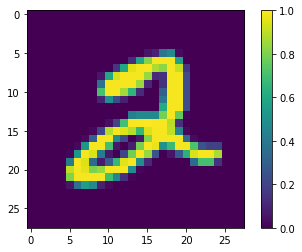

In [ ]:
print(y_train[1])
plt.imshow(x_train[1,:, :,0])
plt.colorbar()

We perform a PCA to resize the dataset. Indeed, we need to respect limits of actual quantum computers. Using a PCA will allow to synthesize in the best way the information of the image and will allow to better train the model.

In [ ]:
def truncate_x(x_train, x_test, n_components=10):
  """Perform PCA on image dataset keeping the top `n_components` components."""
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_test = tf.gather(tf.shape(x_test), 0)

  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])

  # Normalize.
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  feature_mean2= tf.reduce_mean(x_train, axis=0)
  x_test_normalized = x_test - feature_mean2
  # Truncate.
  e_values, e_vectors = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
  e_values_test, e_vectors_test = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_test_normalized, x_test_normalized))
  return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors_test[:, -n_components:])


In [ ]:
DATASET_DIM = 10 #We keep the first 10 components
x_train, x_test = truncate_x(x_train, x_test, n_components=DATASET_DIM)
print(f'New datapoint dimension:', len(x_train[0]))

New datapoint dimension: 10


The final step is to reduce the size of the dataset to only 1000 training data points and 400 test data points.

Indeed, for a too large dataset, the calculation use too much RAM and the code break down. 

In [ ]:
N_TRAIN = 1000
N_TEST = 400
x_train, x_test = x_train[:N_TRAIN], x_test[:N_TEST]
y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]

print("New number of training examples:", len(x_train))
print("New number of test examples:", len(x_test))

New number of training examples: 1000
New number of test examples: 400


In [ ]:
x_train_init, x_test_init = x_train, x_test
y_train_init, y_test_init = y_train, y_test 

## II. Preparation of the quantum dataset

We will now prepare a quantum dataset by incorporating quantum components and relabeling the truncated MNIST dataset we created above. In order to achieve maximum separation between the quantum and classical methods, we will first prepare the PQK (Projected Quantum Kernel) features and then relabel the outputs according to their values.

We will create a new set of features, based on x_train , y_train , x_test and y_test.

First, we  generate the wall of single qubit rotations :

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


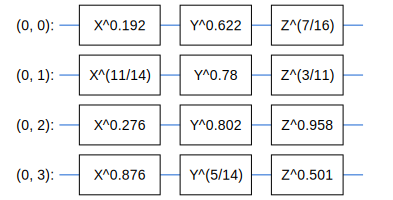

In [ ]:
def single_qubit_wall(qubits, rotations):
  """Prepare a single qubit X,Y,Z rotation wall on `qubits`."""
  wall_circuit = cirq.Circuit()
  for i, qubit in enumerate(qubits):
    for j, gate in enumerate([cirq.X, cirq.Y, cirq.Z]):
      wall_circuit.append(gate(qubit) ** rotations[i][j])

  return wall_circuit
  
SVGCircuit(single_qubit_wall(
    cirq.GridQubit.rect(1,4), np.random.uniform(size=(4, 3)))) #We put in entry a (1,4) quantum circuit and a random uniform vector

Above, we can see the circuit created.

In [ ]:
def v_theta(qubits):
  """Prepares a circuit that generates V(\theta)."""
  ref_paulis = [
      cirq.X(q0) * cirq.X(q1) + \
      cirq.Y(q0) * cirq.Y(q1) + \
      cirq.Z(q0) * cirq.Z(q1) for q0, q1 in zip(qubits, qubits[1:])
  ]
  exp_symbols = list(sympy.symbols('ref_0:'+str(len(ref_paulis))))
  return tfq.util.exponential(ref_paulis, exp_symbols), exp_symbols

We test the circuit with only 2 qubits and see what happen.

Symbols found in circuit:[ref_0]


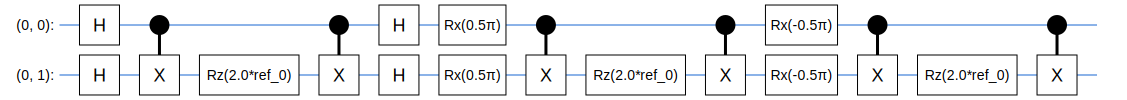

In [ ]:
test_circuit, test_symbols = v_theta(cirq.GridQubit.rect(1, 2))
print(f'Symbols found in circuit:{test_symbols}')
SVGCircuit(test_circuit)

We assemble our complete encoding circuits :

In [ ]:
def prepare_pqk_circuits(qubits, classical_source, n_trotter=10):
  """Prepare the pqk feature circuits around a dataset."""
  n_qubits = len(qubits)
  n_points = len(classical_source)

  # Prepare random single qubit rotation wall.
  random_rots = np.random.uniform(-2, 2, size=(n_qubits, 3))
  initial_U = single_qubit_wall(qubits, random_rots)

  # Prepare parametrized V
  V_circuit, symbols = v_theta(qubits)
  exp_circuit = cirq.Circuit(V_circuit for t in range(n_trotter))

  # Convert to `tf.Tensor`
  initial_U_tensor = tfq.convert_to_tensor([initial_U])
  initial_U_splat = tf.tile(initial_U_tensor, [n_points])

  full_circuits = tfq.layers.AddCircuit()(
      initial_U_splat, append=exp_circuit)
  # Replace placeholders in circuits with values from `classical_source`.
  return tfq.resolve_parameters(
      full_circuits, tf.convert_to_tensor([str(x) for x in symbols]),
      tf.convert_to_tensor(classical_source*(n_qubits/3)/n_trotter))

In [ ]:
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)
# one row and dataset_dim+1 columns
q_x_train_circuits = prepare_pqk_circuits(qubits, x_train)
q_x_test_circuits = prepare_pqk_circuits(qubits, x_test)

Next, we look at the Projected Quantum Kernel characteristics based on the above data set circuits :

In [ ]:
def get_pqk_features(qubits, data_batch):
  """Get PQK features based on above construction."""
  ops = [[cirq.X(q), cirq.Y(q), cirq.Z(q)] for q in qubits]
  ops_tensor = tf.expand_dims(tf.reshape(tfq.convert_to_tensor(ops), -1), 0)
  batch_dim = tf.gather(tf.shape(data_batch), 0)
  ops_splat = tf.tile(ops_tensor, [batch_dim, 1])
  exp_vals = tfq.layers.Expectation()(data_batch, operators=ops_splat)
  rdm = tf.reshape(exp_vals, [batch_dim, len(qubits), -1])
  return rdm

x_train_pqk = get_pqk_features(qubits, q_x_train_circuits)
x_test_pqk = get_pqk_features(qubits, q_x_test_circuits)
print('New PQK training dataset has shape:', x_train_pqk.shape)
print('New PQK testing dataset has shape:', x_test_pqk.shape)

New PQK training dataset has shape: (1000, 11, 3)
New PQK testing dataset has shape: (400, 11, 3)


We will now relabel the dataset.

In [ ]:
def compute_kernel_matrix(vecs, gamma):
  """Computes d[i][j] = e^ -gamma * (vecs[i] - vecs[j]) ** 2 """
  scaled_gamma = gamma / (
      tf.cast(tf.gather(tf.shape(vecs), 1), tf.float32) * tf.math.reduce_std(vecs))
  return scaled_gamma * tf.einsum('ijk->ij',(vecs[:,None,:] - vecs) ** 2)

def get_spectrum(datapoints, gamma=1.0):
  """Compute the eigenvalues and eigenvectors of the kernel of datapoints."""
  KC_qs = compute_kernel_matrix(datapoints, gamma)
  S, V = tf.linalg.eigh(KC_qs)
  S = tf.math.abs(S)
  return S, V

In [ ]:
S_pqk, V_pqk = get_spectrum(
    tf.reshape(tf.concat([x_train_pqk, x_test_pqk], 0), [-1, len(qubits) * 3]))

S_original, V_original = get_spectrum(
    tf.cast(tf.concat([x_train, x_test], 0), tf.float32), gamma=0.005)

print('Eigenvectors of pqk kernel matrix:', V_pqk)
print('Eigenvectors of original kernel matrix:', V_original)

Eigenvectors of pqk kernel matrix: tf.Tensor(
[[-6.5378835e-03  1.4645300e-02  9.3678124e-03 ...  5.0795715e-02
   9.3145519e-03  2.9958054e-02]
 [-1.1528295e-02  9.2674196e-03  2.3717815e-02 ... -3.0975849e-03
  -5.9624499e-01  2.0246316e-02]
 [-2.5909739e-02  3.1283773e-02  2.7836923e-02 ... -4.4062812e-02
  -9.4857058e-03  2.8485989e-02]
 ...
 [ 3.1641021e-02 -1.6949980e-02 -6.5427028e-02 ...  1.5171440e-04
   8.6336397e-03  2.9045550e-02]
 [ 3.5175800e-02 -1.3350930e-02 -2.2306785e-02 ...  7.9050185e-03
  -3.9254449e-02  2.1312255e-02]
 [ 3.8112450e-02 -6.1869773e-04  2.0116564e-02 ...  3.0284854e-02
   6.4382153e-03  2.5832606e-02]], shape=(1400, 1400), dtype=float32)
Eigenvectors of original kernel matrix: tf.Tensor(
[[-0.01415992 -0.05327218 -0.00836787 ...  0.00584241 -0.00389914
   0.02479831]
 [ 0.02886272  0.00985301 -0.02919026 ...  0.00918429 -0.7119057
   0.02629017]
 [-0.02465827  0.04842722 -0.00427832 ... -0.03575666 -0.00394017
   0.02912825]
 ...
 [ 0.02482575 -0.038

In [ ]:
def get_stilted_dataset(S, V, S_2, V_2, lambdav=1.1):
  """Prepare new labels that maximize geometric distance between kernels."""
  S_diag = tf.linalg.diag(S ** 0.5)
  S_2_diag = tf.linalg.diag(S_2 / (S_2 + lambdav) ** 2)
  scaling = S_diag @ tf.transpose(V) @ \
            V_2 @ S_2_diag @ tf.transpose(V_2) @ \
            V @ S_diag

  # Generate new lables using the largest eigenvector.
  _, vecs = tf.linalg.eig(scaling)
  new_labels = tf.math.real(
      tf.einsum('ij,j->i', tf.cast(V @ S_diag, tf.complex64), vecs[-1])).numpy()
  # Create new labels and add some small amount of noise.
  final_y = new_labels > np.median(new_labels)
  noisy_y = (final_y ^ (np.random.uniform(size=final_y.shape) > 0.95))
  return noisy_y

In [ ]:
y_relabel = get_stilted_dataset(S_pqk, V_pqk, S_original, V_original)
y_train_new, y_test_new = y_relabel[:N_TRAIN], y_relabel[N_TRAIN:]

In [ ]:
print("Shape of x_test : "+str(x_test.shape))
print("Shape of x_test_pqk : "+str(x_test_pqk.shape))

Shape of x_test : (400, 10)
Shape of x_test_pqk : (400, 11, 3)


We have prepared our dataset and now we will compare performances of our model. We will compare performances when we give access to the PQK features of x_train_pqk, and when we use a classical model.

## III. Creation and training of Projected Quantum Kernel models
### III.A Dense model
We create a Projected Quantum Kernel model with only dense layer


In [ ]:
def create_pqk_model_dense():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[len(qubits)*3,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

pqk_model = create_pqk_model_dense()
pqk_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

pqk_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# We train this model on 1000 EPOCHS
EPOCHS=1000
pqk_history = pqk_model.fit(tf.reshape(x_train_pqk, [N_TRAIN, -1]),
          y_train_new,
          batch_size=32,
          epochs=EPOCHS,
          verbose=2,
          validation_data=(tf.reshape(x_test_pqk, [N_TEST, -1]), y_test_new))

Epoch 1/1000
32/32 - 1s - loss: 0.6899 - accuracy: 0.5560 - val_loss: 0.7276 - val_accuracy: 0.3525
Epoch 2/1000
32/32 - 0s - loss: 0.6813 - accuracy: 0.5560 - val_loss: 0.7396 - val_accuracy: 0.3525
Epoch 3/1000
32/32 - 0s - loss: 0.6711 - accuracy: 0.5560 - val_loss: 0.7777 - val_accuracy: 0.3525
Epoch 4/1000
32/32 - 0s - loss: 0.6585 - accuracy: 0.5560 - val_loss: 0.7426 - val_accuracy: 0.3525
Epoch 5/1000
32/32 - 0s - loss: 0.6378 - accuracy: 0.5620 - val_loss: 0.8386 - val_accuracy: 0.3525
Epoch 6/1000
32/32 - 0s - loss: 0.6141 - accuracy: 0.6030 - val_loss: 0.8465 - val_accuracy: 0.3550
Epoch 7/1000
32/32 - 0s - loss: 0.5940 - accuracy: 0.6540 - val_loss: 0.9112 - val_accuracy: 0.3550
Epoch 8/1000
32/32 - 0s - loss: 0.5747 - accuracy: 0.6930 - val_loss: 0.9731 - val_accuracy: 0.3650
Epoch 9/1000
32/32 - 0s - loss: 0.5628 - accuracy: 0.6950 - val_loss: 0.9692 - val_accuracy: 0.3750
Epoch 10/1000
32/32 - 0s - loss: 0.5556 - accuracy: 0.7090 - val_loss: 0.9902 - val_accuracy: 0.3825

### III.B Convolutive model
We then create and train Projected Quantum Kernel convolutive model. This model will be based on convolutives layers

In [ ]:
def create_pqk_model_convolutional():
    model = tf.keras.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1, input_shape=(x_train_pqk.shape[1],x_train_pqk.shape[2],1)))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Conv2D(16, (3, 1), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model
  

pqk_model_conv = create_pqk_model_convolutional()
pqk_model_conv.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

pqk_model_conv.summary()
pqk_history_conv = pqk_model_conv.fit(x_train_pqk, 
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=2,
          validation_data=(x_test_pqk, y_test_new))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 11, 3, 1)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 1, 16)          160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 1, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 1, 16)          784       
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

### III.C Comparison between convolutive and dense Projected Quantum Kernel models

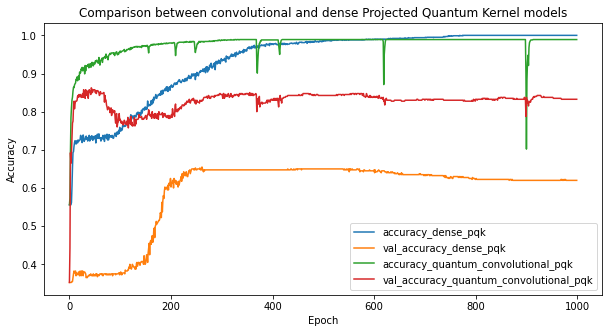

In [ ]:
plt.figure(figsize=(10,5))
#plt.plot(classical_history.history['accuracy'], label='accuracy_classical')
#plt.plot(classical_history.history['val_accuracy'], label='val_accuracy_classical')
plt.plot(pqk_history.history['accuracy'], label='accuracy_dense_pqk')
plt.plot(pqk_history.history['val_accuracy'], label='val_accuracy_dense_pqk')
plt.plot(pqk_history_conv.history['accuracy'], label='accuracy_quantum_convolutional_pqk')
plt.plot(pqk_history_conv.history['val_accuracy'], label='val_accuracy_quantum_convolutional_pqk')
plt.title("Comparison between convolutional and dense Projected Quantum Kernel models") 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

We can see that after few epochs, the convolutive model is more reliable. This model have also better performance on the validation dataset. However, the convolutive model seems to be less stable then the dense one.

## IV. Comparison with classical models

We now create a dense classical model and a convolutive calssical model which have not access to the PKQ features. It will enables us to compare PQK and classical model

### IV.A Comparison of denses models

In [ ]:
def create_fair_classical_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[DATASET_DIM,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

model.summary()
classical_history = model.fit(x_train,
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=2,
          validation_data=(x_test, y_test_new))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
32/32 - 1s - loss: 0.6842 - accuracy: 0.5560 - val_loss: 0.7177 - val_accuracy: 0.3525
Epoch 2/1000
32/32 - 0s - loss: 0.6818 - accuracy: 0.5560 - val_loss: 0.7573 - val_accuracy: 0.3525
Epoch 3/1000
32/32 - 0s - loss: 0.6766 - accuracy: 0.5560 - val_loss: 0.7686 - val_accuracy: 0.3525
Epoch 4/1000
32/32 - 0s - loss: 0.6744 - accuracy: 0.5560 - val_loss: 0.7686 - val_acc

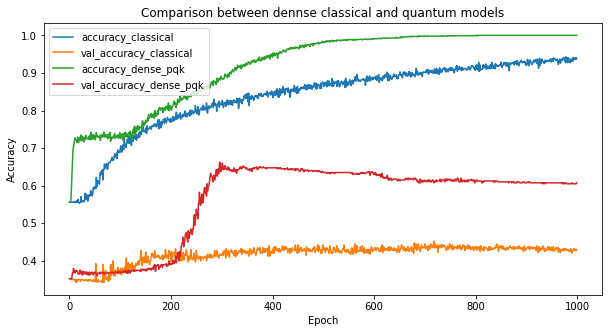

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(classical_history.history['accuracy'], label='accuracy_classical')
plt.plot(classical_history.history['val_accuracy'], label='val_accuracy_classical')
plt.plot(pqk_history.history['accuracy'], label='accuracy_dense_pqk')
plt.plot(pqk_history.history['val_accuracy'], label='val_accuracy_dense_pqk')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Comparison between dense classical and quantum models")
plt.legend()

In [ ]:
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

In [ ]:
def create_fair_classical_model_convolutive():
    model = tf.keras.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1, input_shape=(x_train.shape[1],x_train.shape[2],1)))
    model.add(tf.keras.layers.Conv2D(16, (1, 1), activation='relu'))
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Conv2D(16, (3, 1), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model
    

model = create_fair_classical_model_convolutive()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

model.summary()

classical_history_convolutive = model.fit(x_train,
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(x_test, y_test_new))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 10, 1, 1)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 1, 16)         32        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 1, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 1, 16)          784       
_________________________________________________________________
flatten_1 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                784       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

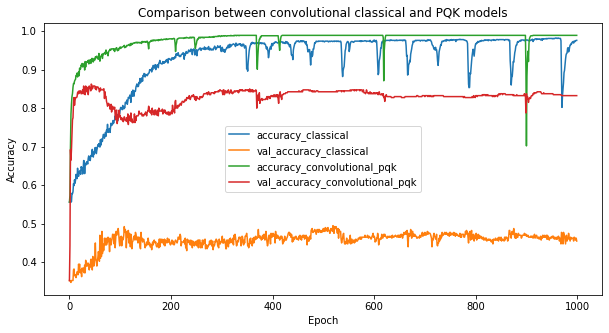

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(classical_history_convolutive.history['accuracy'], label='accuracy_classical')
plt.plot(classical_history_convolutive.history['val_accuracy'], label='val_accuracy_classical')
plt.plot(pqk_history_conv.history['accuracy'], label='accuracy_convolutional_pqk')
plt.plot(pqk_history_conv.history['val_accuracy'], label='val_accuracy_convolutional_pqk')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Comparison between convolutional classical and PQK models")
plt.legend()



We can see that the val_accuracy for the quantum model is much more better than for the calssical model.